# Lepton - Jet Asymmetry

### $\phi$ is defined as the angle between the total transverse momentum of the system,

### $\vec{q}_\perp = \vec{k}_{\ell\perp} + \vec{k}_{J\perp}$, 

### and the jet relative momentum,

### $\vec{P_\perp} = (\vec{k}_{\ell\perp} - \vec{k}_{J\perp})/2$

### Thus:

### $\cos(\phi) = (\vec{q}_\perp \cdot \vec{P_\perp})\ /\ |\vec{q}_\perp| |\vec{P_\perp}|$

### and $\phi = \mathrm{acos}[(\vec{q}_\perp \cdot \vec{P_\perp})\ /\ |\vec{q}_\perp| |\vec{P_\perp}|]$

### Assumption: Perturbative iff $\vec{q}_\perp << \vec{P_\perp}$

### Note: $\hat{t} = (k_l-k)^2 = -Q^2$

https://arxiv.org/pdf/2106.05307.pdf

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from matplotlib import gridspec
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import h5py

import os
os.environ['CUDA_VISIBLE_DEVICES']="3" #CHECK THIS IF THE MODELS DON'T LOAD!!

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

tf.config.experimental.set_memory_growth(physical_devices[0], True)

from matplotlib import style
style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read in Data and MC

In [2]:
data = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Data_nominal.pkl")
mc = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Django_nominal.pkl")
#rapgap_df = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Rapgap_nominal.pkl")

In [3]:
print(len(mc))
93608656

93608656


93608656

### Select Leading Jets Only

In [4]:
one_jet_events_only = False
if (one_jet_events_only):
    njets_tot = len(data["jet_pt"])
    data = data.loc[(slice(None),0), :]
    mc = mc.loc[(slice(None),0), :]
    print("Number of subjets cut = ",njets_tot-len(data["e_px"])," / ",len(data["jet_pt"]))

In [5]:
print(len(mc))

93608656


### $\theta_{\mathrm{unknown}S}$

In [6]:
theta_unknown_S = data[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()
scaler_data = StandardScaler()
scaler_data.fit(theta_unknown_S)

StandardScaler()

### $\theta_{G}$

In [7]:
theta0_G = mc[['gene_px','gene_py','gene_pz','genjet_pt','genjet_eta','genjet_phi','genjet_dphi','genjet_qtnorm']].to_numpy()
weights_MC_sim = mc['wgt']
pass_reco = np.array(mc['pass_reco'])
pass_truth = np.array(mc['pass_truth'])
pass_fiducial = np.array(mc['pass_fiducial'])
del mc
_ = gc.collect()

In [8]:
print(np.sum(pass_fiducial)/len(pass_fiducial))

0.14067516363016686


In [9]:
print(np.shape(theta0_G[:,0:8]))
print(np.shape(theta0_G))
print(theta0_G)

(93608656, 8)
(93608656, 8)
[[ -4.7957945   12.92987    -17.290243   ...   5.113636     0.04606843
    0.04844606]
 [ -4.7957945   12.92987    -17.290243   ...   1.3230405    2.5386581
    1.0600959 ]
 [ -5.8020964    4.2962174  -21.620358   ...   5.7377605    0.09194237
    0.15532045]
 ...
 [ -2.06779      4.8814116  -11.738547   ...   4.4478073    2.4763224
    0.43498355]
 [-11.084353    29.466581   -11.371146   ...   5.5719113    0.4997291
    0.51432097]
 [-11.084353    29.466581   -11.371146   ...   3.5183694    1.5877799
    0.96932036]]


In [10]:
print(len(theta0_G))

93608656


### Step 2 NN Weights

In [11]:
NNweights_step2 = np.ones(len(theta0_G))
for i in range(5):
    mymodel = tf.keras.models.load_model("../../disjets/inputfiles/fullscan3/models/Django_nominal_iteration"+str(i)+"_step2", compile=False)
    NNweights_step2_hold = mymodel.predict(scaler_data.transform(theta0_G),batch_size=10000)
    NNweights_step2_hold = NNweights_step2_hold/(1.-NNweights_step2_hold)
    NNweights_step2_hold = NNweights_step2_hold[:,0]
    NNweights_step2_hold = np.squeeze(np.nan_to_num(NNweights_step2_hold,posinf=1))
    NNweights_step2_hold[pass_truth==0] = 1.
    NNweights_step2 = NNweights_step2_hold*NNweights_step2

2022-10-17 15:09:39.764930: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 15:09:40.281920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22852 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:c1:00.0, compute capability: 7.5
2022-10-17 15:09:47.509240: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
weights = weights_MC_sim*NNweights_step2

In [13]:
print(len(weights))

93608656


---

### $\vec{q}_\perp = \vec{k}_{\ell\perp} + \vec{k}_{J\perp}$  and  $\vec{P_\perp} = (\vec{k}_{\ell\perp} - \vec{k}_{J\perp})/2$
### $\cos(\phi) = (\vec{q}_\perp \cdot \vec{P_\perp})\ /\ |\vec{q}_\perp| |\vec{P_\perp}|$

In [14]:
e_px = theta0_G[:,0]
e_py = theta0_G[:,1]

jet_pT_mag = theta0_G[:,3]
jet_phi = theta0_G[:,5]

jet_qT = theta0_G[:,7] #[not to be confused with q_Perp!]

print(min(jet_phi),max(jet_phi))
print(min(jet_pT_mag))

jet_px = np.multiply(jet_pT_mag, np.cos(jet_phi))
jet_py = np.multiply(jet_pT_mag, np.sin(jet_phi))

jet_pT = np.array([jet_px,jet_py])
e_pT = np.array([e_px,e_py])

q_perp_vec = jet_pT + e_pT
P_perp_vec = (e_pT-jet_pT)/2

q_perp_mag = np.linalg.norm(q_perp_vec,axis=0)
P_perp_mag = np.linalg.norm(P_perp_vec,axis=0)



q_dot_P = q_perp_vec[0,:]*P_perp_vec[0,:] + q_perp_vec[1,:]*P_perp_vec[1,:]

cosphi = (q_dot_P)/(q_perp_mag*P_perp_mag)
asymm_phi = np.arccos(cosphi)
#7.32459e-08 6.283185
print(np.shape(q_perp_mag))
print(np.shape(jet_phi))
print(np.shape(asymm_phi))

5.4230136e-09 6.283185
3.0
(93608656,)
(93608656,)
(93608656,)


/tmp/ipykernel_11583/2981445407.py:29: RuntimeWarning: invalid value encountered in arccos
  asymm_phi = np.arccos(cosphi)


### Define Cuts

In [15]:
#pass_fiducial created under theta_G
pT_cut = jet_pT_mag > 10.
q_over_pT_cut = q_perp_mag/jet_pT_mag < 0.3 #Kyle guessed ~0.3, needs variation
qT_cut = np.where((jet_qT<0.25), True, False)
phi_nan_cut = ~np.isnan(asymm_phi)
#q_perp_cut = q_perp_mag < 10.0 #q_perp_max

print(np.shape(pT_cut))
#print(np.shape(q_perp_cut))


cut_arrays = [pass_fiducial,
              pT_cut,
              q_over_pT_cut,
              qT_cut,
              phi_nan_cut]
              #q_perp_cut]

cuts = np.ones(len(pT_cut))

for cut in cut_arrays:
    cuts = np.logical_and(cuts,cut)

(93608656,)


___

### Asymmetry Histogram

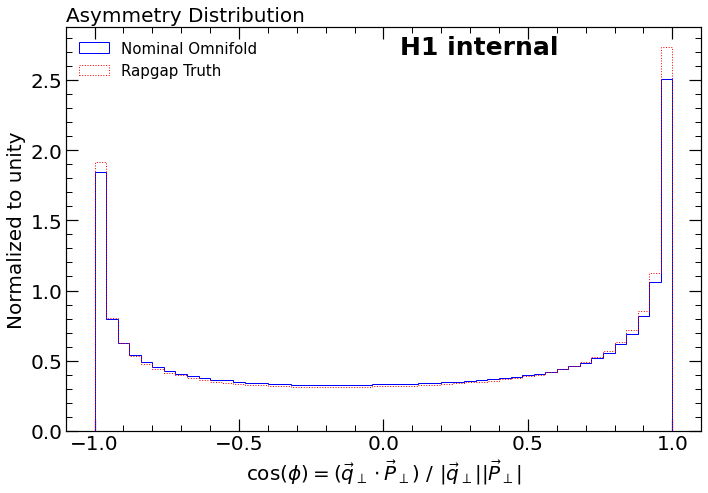

In [16]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)
#bin_for_angle = np.linspace(0,3,18)
bin_for_angle = np.linspace(-1,1,51)

a_data,b_data,c=plt.hist(cosphi[cuts], bins = bin_for_angle,
                weights=weights_MC_sim[cuts]*NNweights_step2[cuts],
                density=True,histtype="step",color="blue",ls="-",label="Nominal Omnifold")

a_sim,b_sim,c=plt.hist(cosphi[cuts], bins = bin_for_angle,
                weights=weights_MC_sim[cuts],
                density=True,histtype="step",color="red",ls=":",label="Rapgap Truth")

plt.ylabel("Normalized to unity",fontsize=20)
plt.title("Asymmetry Distribution ",loc="left",fontsize=20)
plt.text(0.65, 0.95,'H1 internal', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.legend(frameon=False,fontsize=15,loc='upper left')
plt.locator_params(axis='x', nbins=5)
#plt.yscale("log")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20),

#plt.xlabel(r"$cos(\phi) = q_T\cdot e_{p_T}/(|q_T|\cdot|e_{p_T}|)$",fontsize=15)
plt.xlabel(r'cos($\phi) = (\vec{q}_\perp \cdot \vec{P}_\perp)\ /\ |\vec{q}_\perp| |\vec{P}_\perp|$',fontsize=20)

plt.savefig("H1_Angle_Distribution.pdf")
plt.tight_layout()
plt.show()

## Bootstrapped Errors

In [17]:
N_Bootstraps= 100
boot_ensemble = np.random.poisson(1,(N_Bootstraps,len(data)))
N_Events = len(data)
print(N_Events)

258684


In [18]:
#np.save('qT_masks',qT_masks)
np.save('jet_pT',jet_pT_mag)
np.save('cuts',cuts)
np.save('q_perp',q_perp_mag)
np.save('asymm_angle',asymm_phi)
np.save('weights',weights)
np.save("nn_weights",NNweights_step2)
np.save("mc_weights",weights_MC_sim)
np.save("N_Data",N_Events)